In [ ]:
# car racer image processing development dataset exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label,binary_dilation
from scipy.spatial import distance

In [2]:
data = np.load('/Users/Finn/desktop/racer_data_small.npz')
data.files

['obs', 'action', 'new_obs', 'reward', 'terminated', 'preds']

In [21]:
def colour_selection(obs):
    ''' a filter used for isolating the track '''
    assert obs.shape == (96,96,3), 'expecting raw image'
    # select just the upper part of the image with :84
    red_component = (obs[:84,:,0] < 120)
    green_component = (obs[:84,:,1]>110)
    return red_component * green_component


def get_edge(obs):

    ''' ---- get edges --- '''
    # puts labels on the disconnected fields
    labeled_array, num_features = label(colour_selection(obs))
    # consolidate edges
    track_edges = np.zeros(labeled_array.shape + (num_features,))
    for i in range(num_features):
        track_edges[:,:,i] = binary_dilation(labeled_array==i+1) ^ (labeled_array==i+1)
#    return np.array(track_edges) # development output

    ''' ---- determine left and right-ness ---- '''
    labeled_edges, num_features = label(binary_dilation(track_edges.sum(axis=-1)))
#    return labeled_edges # development output

    counts = list()
    for i in range(1,num_features+1):
        counts.append((labeled_edges==i).sum()) # use the fat edges
    counts = np.array(counts)
    best_label = counts.argmax()
    
    if best_label >= track_edges.shape[2]:
        # exit if not enough track was found
        return
        
    best_mask = np.zeros(len(counts),dtype=bool)
    best_mask[best_label] = True

    main_edge = track_edges[:,:,best_label]
    other_edge = track_edges[:,:,~best_mask]
    if len(other_edge.shape) >2:
        other_edge = other_edge.sum(axis=-1)
#    return other_edge, main_edge # development output

    edge1_pixels = np.array(np.where(main_edge)).T
    edge2_pixels = np.array(np.where(other_edge)).T

    return edge1_pixels, edge2_pixels
    

In [22]:
main_edge, other_edge = get_edge(data['obs'][4])

def get_mid(edge_lists, downsample = 1):
    edges1, edges2 = edge_lists
    edges1 = edges1[::downsample]
    edges2 = edges2[::downsample]
    
    # shuffle points
    np.random.shuffle(edges1)
    np.random.shuffle(edges2)
    if len(edges1) > len(edges2): # loop through shorter
        edges2, edges1 = edges1, edges2
    
    distances = distance.cdist(edges1, edges2) # some downsampling of them
    nearest_indices = distances.argmin(axis=1)
    
    mids = list()
    for _idx, _partner in enumerate(nearest_indices):
        mids.append((edges1[_idx] + edges2[_partner])/2)
    return np.array(mids)
        
mids = get_mid([main_edge, other_edge], downsample=1)

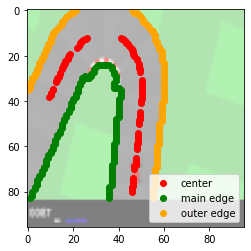

In [23]:
plt.imshow(data['obs'][4],alpha=0.5)
plt.scatter(mids[:,1], mids[:,0],c='r',label = 'center')
plt.scatter(main_edge[:,1],main_edge[:,0],c='g',label='main edge')
plt.scatter(other_edge[:,1],other_edge[:,0],c='orange',label='outer edge')
plt.legend()

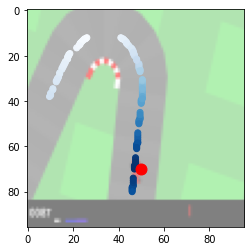

In [24]:
''' --- calculate distance to center of track --- '''

car_position = np.array((70,50))

cs = np.linalg.norm(mids - car_position,axis=1)

plt.imshow(data['obs'][4],alpha=0.5)
plt.scatter(mids[:,1], mids[:,0],c=cs,cmap='Blues_r')
plt.scatter(car_position[1],
            car_position[0],
            marker='o',c='r',s=120)



In [ ]:
fig,ax = plt.subplots(5,5,figsize=(15,15))

i = 0
state_i = 0 
while i < 25:
    try:
        main_edge, other_edge = get_edge(data['obs'][state_i])
        mids = get_mid([main_edge, other_edge],downsample=5)

        ax[i%5][i//5].scatter(mids[:,1], mids[:,0],c='r')
        ax[i%5][i//5].imshow(data['obs'][state_i],alpha=0.4)
        ax[i%5][i//5].set_xticks([])
        ax[i%5][i//5].set_yticks([])
        ax[i%5][i//5].set_title('index:' + str(state_i))
        i+=1
        state_i += 1
    except:
        state_i+=1

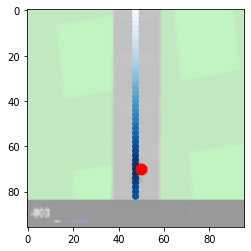

In [29]:
state_index = 8

main_edge, other_edge = get_edge(data['obs'][state_index])
mids = get_mid([main_edge, other_edge],downsample=2)

cs = np.linalg.norm(mids - np.array(car_position),axis=1)

plt.imshow(data['obs'][state_index],alpha=0.4)
plt.scatter(mids[:,1], mids[:,0],c=cs,cmap='Blues_r')
plt.scatter(car_position[1],
            car_position[0],
            marker='o',c='r',s=120)